# Functions

In [0]:
""" Create the new feature"""
def Year_interval(hp_data,Year):
    Yrcols = ['YearBuilt','YearRemodAdd']
    hp_tempData = Year - hp_data[Yrcols]
    hp_tempData.columns = ['YearBuilt_Reg','YearRemodAdd_Reg']
    hp_data = pd.concat([hp_data,hp_tempData],axis=1)
    hp_data = hp_data.drop(Yrcols,axis =1)
    return hp_data
  
  
""" Analyse Outliers """    
def bivrt_df_scatter(x,y,data=None,title=None,xlabel = None,ylabel=None):
    if isinstance(data,pd.DataFrame):
      df = pd.concat([data[x], data[y]], axis=1)
      df.plot.scatter(x=x, y=y,title = title )
    else:
      plt.scatter(x=x, y=y)
      plt.title(title)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
    plt.show()
    
    
""" Solving Normality To Prevent Heteroscedasticity"""
def NormSolver(hp_data):

    """----GrLivArea----"""
    #Before
    #histogram and normal probability plot
    sns.distplot(hp_data['GrLivArea'], fit=stats.norm,ax= ax[0][2],color ='m').set_title('Before') # fit=stats.norm: Insert expected bell shape for the data
    stats.probplot(hp_data['GrLivArea'], plot=ax[0][3])
    ax[0][3].get_lines()[0].set_markerfacecolor('m')
    #skewness and kurtosis
    gla_bf_skew = hp_data['GrLivArea'].skew()
    gla_bf_kurt = hp_data['GrLivArea'].kurt()
    print('---GrLivArea (Before)---')
    print("Skewness: %f" % gla_bf_skew)
    print("Kurtosis: %f" % gla_bf_kurt)
    
    #After
    #applying log transformation
    hp_data['GrLivArea'] = np.log(hp_data['GrLivArea'])
    #histogram and normal probability plot
    sns.distplot(hp_data['GrLivArea'], fit=stats.norm,ax= ax[1][2],color ='m').set_title('After')
    stats.probplot(hp_data['GrLivArea'], plot=ax[1][3])
    ax[1][3].get_lines()[0].set_markerfacecolor('m')
    #skewness and kurtosis
    gla_af_skew = hp_data['GrLivArea'].skew()
    gla_af_kurt = hp_data['GrLivArea'].kurt()
    print('---GrLivArea (After)---')
    print("Skewness: %f" % gla_af_skew)
    print("Kurtosis: %f" % gla_af_kurt)
    
    """----TotalBsmtSF----"""
    #Before
    #histogram and normal probability plot
    sns.distplot(hp_data['TotalBsmtSF'], fit=stats.norm,ax= ax[0][4],color ='g').set_title('Before')
    stats.probplot(hp_data['TotalBsmtSF'], plot=ax[0][5])
    ax[0][5].get_lines()[0].set_markerfacecolor('g')
    #skewness and kurtosis
    tbs_bf_skew = hp_data['TotalBsmtSF'].skew()
    tbs_bf_kurt = hp_data['TotalBsmtSF'].kurt()
    print('---TotalBsmtSF (Before)---')
    print("Skewness: %f" % tbs_bf_skew)
    print("Kurtosis: %f" % tbs_bf_kurt)
    
    #After
    #Log transformation : log tranf -> 0 , get -inf
    hp_data['TotalBsmtSF'] = np.log(hp_data['TotalBsmtSF'])
    #Replace -inf or inf to 0 ; inplace = True : Overwrite to hp_data
    hp_data['TotalBsmtSF'].replace([np.inf, -np.inf], 0, inplace = True)
    #histogram and normal probability plot without 0
    sns.distplot(hp_data[hp_data['TotalBsmtSF']>0]['TotalBsmtSF'], fit=stats.norm,ax=ax[1][4],color ='g').set_title('After')
    stats.probplot(hp_data[hp_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot=ax[1][5])
    ax[1][5].get_lines()[0].set_markerfacecolor('g')
    #skewness and kurtosis
    tbs_af_skew = hp_data['TotalBsmtSF'].skew()
    tbs_af_kurt = hp_data['TotalBsmtSF'].kurt()
    print('---TotalBsmtSF (After)---')
    print("Skewness: %f" % tbs_af_skew)
    print("Kurtosis: %f" % tbs_af_kurt)
    
    skew_kurt_bf = {'gla_bf_skew': gla_bf_skew ,'gla_bf_kurt': gla_bf_kurt,
                    'tbs_bf_skew': tbs_bf_skew ,'tbs_bf_kurt': tbs_bf_kurt,               
                    }
    
    skew_kurt_af = {'gla_af_skew': gla_af_skew ,'gla_af_kurt': gla_af_kurt,
                    'tbs_af_skew': tbs_af_skew ,'tbs_af_kurt': tbs_af_kurt                 
                    }
    
    return [hp_data,skew_kurt_bf,skew_kurt_af]

    

# Main Code



In [15]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os,re
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import skew,kurtosis

from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_log_error
from sklearn.linear_model import LinearRegression

from process_dataset import regression_dataset as regds
from evaluate_model import reg_eval



""" ***************** """
"""  Extract Dataset  """
""" ***************** """

#----Kaggle----
# hp_train_path = '../input/train.csv'
# hp_test_path = '../input/test.csv'
#----Kaggle----

#----Colab----
main_dir = '/content'
hp_train_path = os.path.join(main_dir,'train.csv')
hp_test_path = os.path.join(main_dir,'test.csv')
#----Colab----


hp_train_data = pd.read_csv(hp_train_path)
hp_test_data = pd.read_csv(hp_test_path)

hp_train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## Training data pre-processing

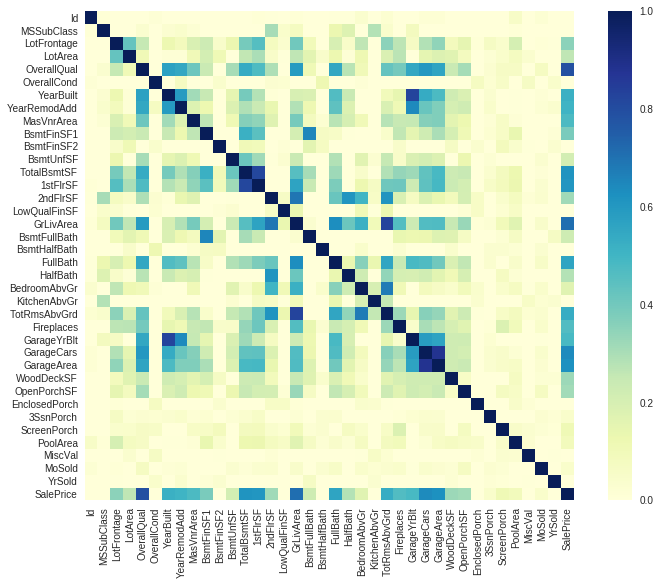

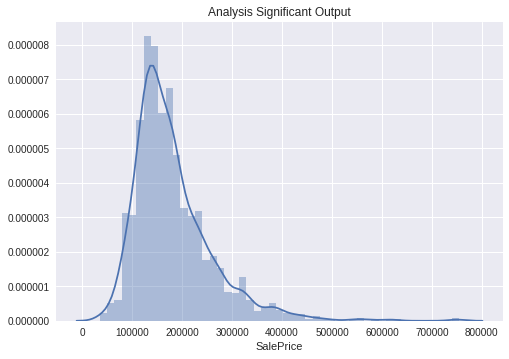

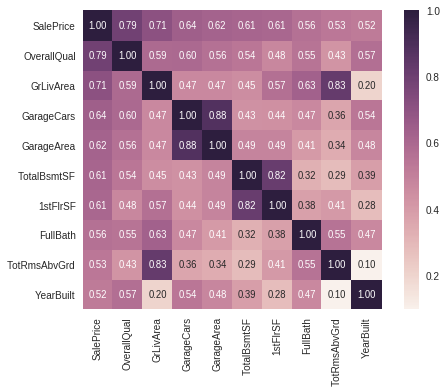

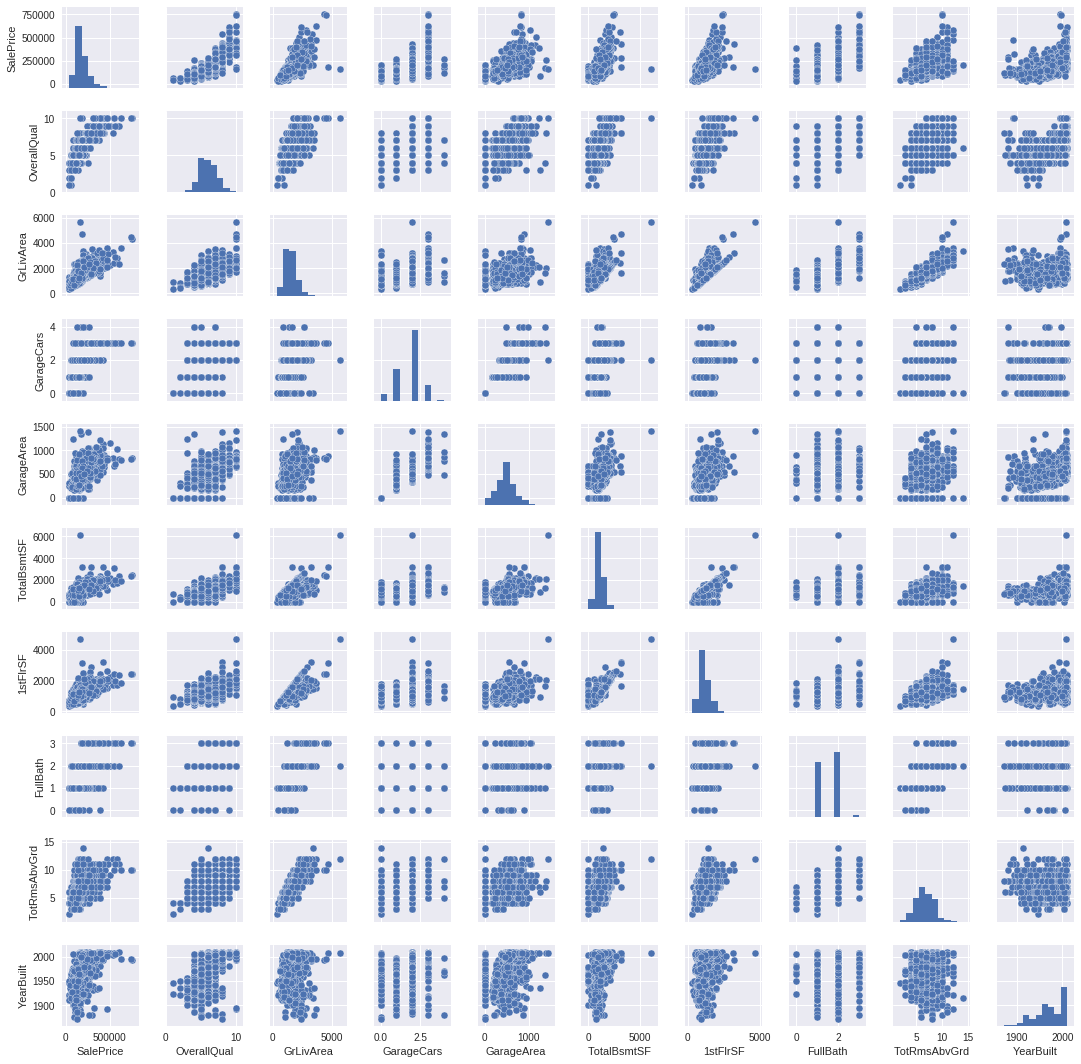

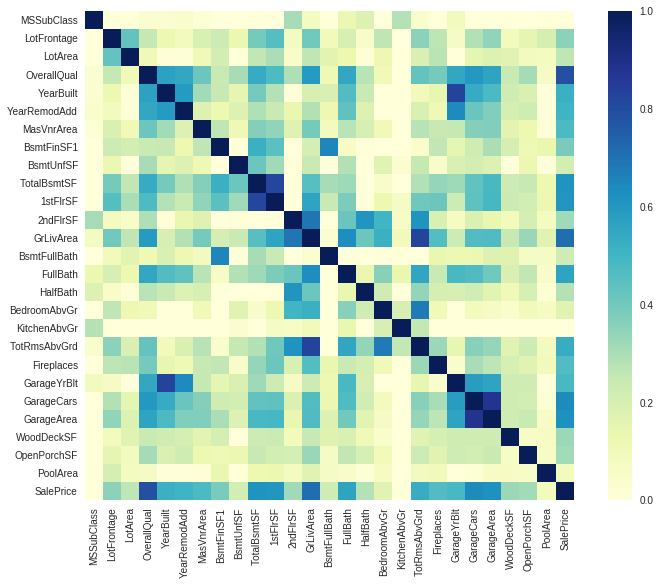

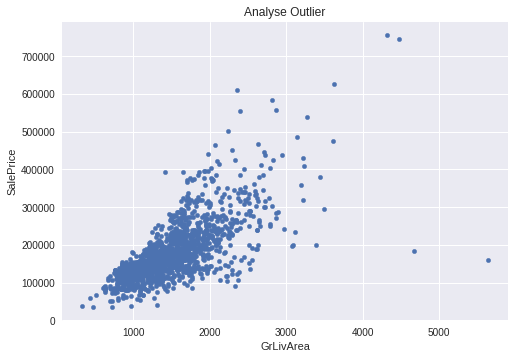

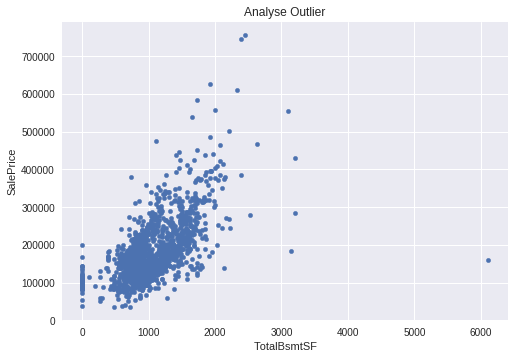

---SalePrice (Before)---
Skewness: 1.881296
Kurtosis: 6.523067
---SalePrice (After)---
Skewness: 0.121568
Kurtosis: 0.804764
---GrLivArea (Before)---
Skewness: 1.010992
Kurtosis: 2.063463
---GrLivArea (After)---
Skewness: -0.071819
Kurtosis: 0.096331
---TotalBsmtSF (Before)---
Skewness: 0.511703
Kurtosis: 1.770105
---TotalBsmtSF (After)---
Skewness: -5.170369
Kurtosis: 27.813993


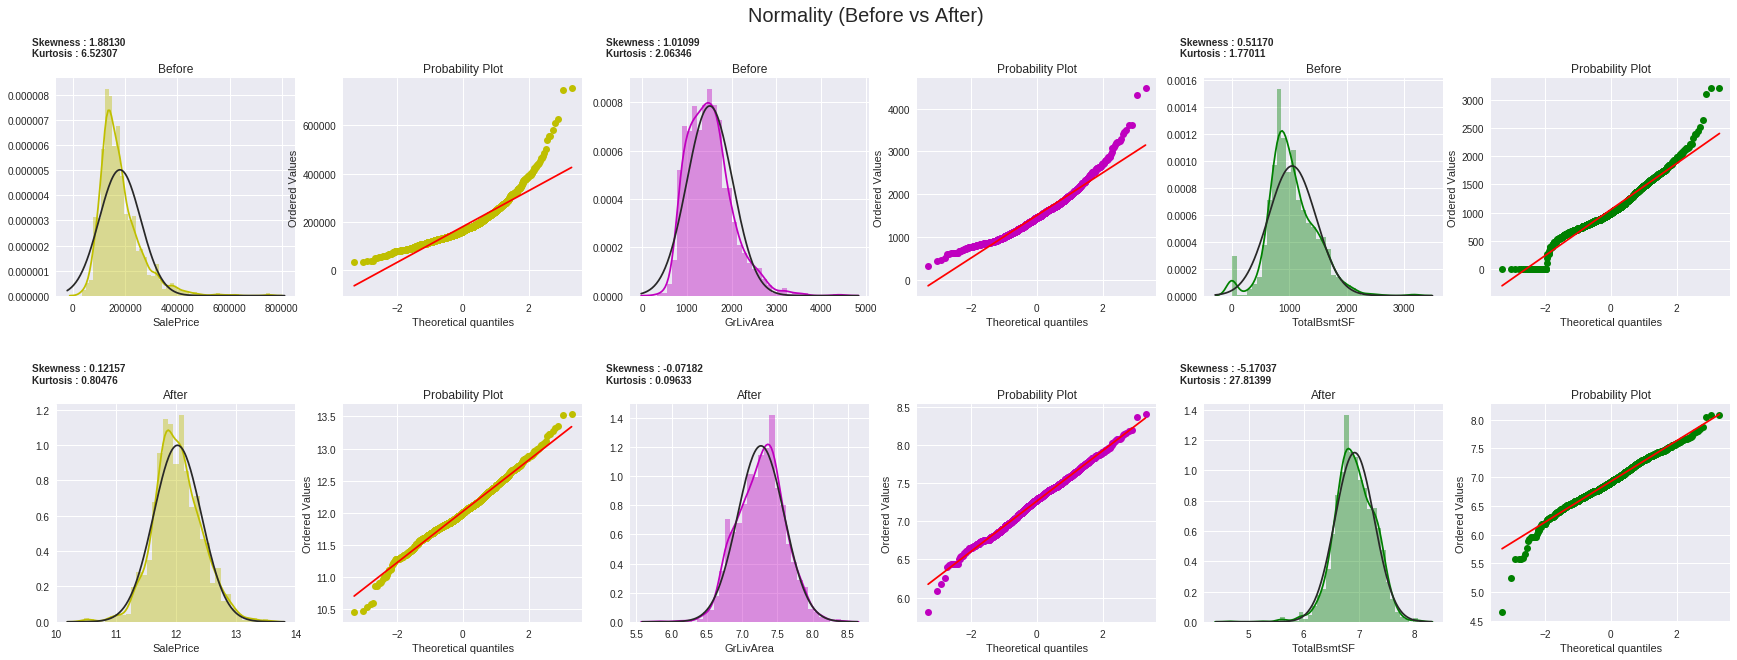

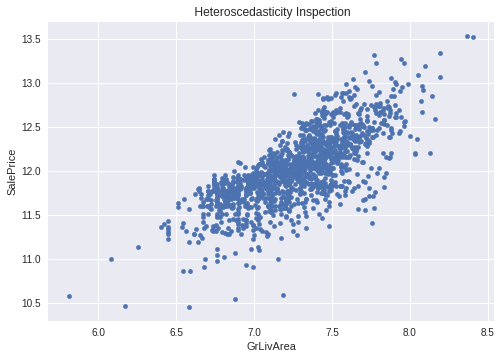

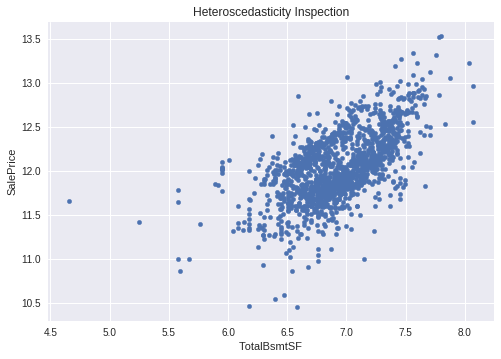

(1458, 180)

In [5]:
""" Check dataset """
#Check what does the dataset looks like
hp_train_data.columns
hp_train_data.shape #(1460, 81)
hp_train_data.head()


""" Correlation Matrix (heatmap style)  (Train data only)  """
#Identify the relationship across all the variables
corrmat = hp_train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmin = 0,vmax=1,square=True,cmap="YlGnBu",ax=ax)
plt.show() #not mix with other similar graph


""" Analysis Significant Output (SalePrice)  (Train data only)  """
#SalePrice is the output for later prediction model
#It is important that need to check its properties. Ex: min > 0 , mean no abnormal price happen
hp_train_data.SalePrice.describe()
#Plot histogram (Normal distribution)
sns.distplot(hp_train_data.SalePrice).set_title('Analysis Significant Output')
plt.show()


""" Analysis The Relationship Btw Output(SalePrice) and Correlated Variables  (Train data only)   """
#Get top n largest value order by SalePrice,then get the dataframe index because its  position changed.
cols = corrmat.nlargest(10, 'SalePrice').index
corrmat2 = hp_train_data[cols].corr() #pandas method; .corr() : direct use for dataframe
sns.set(font_scale=1)
sns.heatmap(corrmat2, annot=True,annot_kws={'size': 9.5}, square=True, fmt='.2f')
plt.show()

#Pair plots between 'SalePrice' and correlated variables
sns.set() #RESET
sns.pairplot(hp_train_data[cols], size = 1.5)
plt.show()


""" --------------------- """
"""  Feature Engineering  """
""" --------------------- """

""" Remove Unwanted Features  """
Rem_cols_train = []
corrmat_reg = hp_train_data.corr()
#keep value > 0.2 else become Nan
Filtered_Corr = corrmat_reg[corrmat_reg > 0.2]
for fc in Filtered_Corr.columns:
    #If equal 1, means only 1 value present and others are Nan, then this cols need to be removed
     if Filtered_Corr[fc].value_counts().sum() <= 1:
         Rem_cols_train.append(fc)
hp_train_data.drop(Rem_cols_train,axis = 1,inplace = True)

#Show the heatmap
corrmat_rev = hp_train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_rev,vmin = 0,vmax=1,square=True,cmap="YlGnBu",ax=ax)
plt.show() #not mix with other similar graph


""" Display Missing Data """
missing_data = regds.disp_miss_data(hp_train_data)
missing_data.head(20)


""" Imputation for missing data"""
#After examine the missing data, delete all the features except that with one miss data
Miss_cols = (missing_data[missing_data['Total'] > 1]).index
hp_train_data = hp_train_data.drop(Miss_cols,axis = 1)

#Fill in nan with common info in specific columns
ComInfo_Elec = hp_train_data['Electrical'].value_counts().argmax()
hp_train_data['Electrical'].fillna(ComInfo_Elec, inplace = True)
#just checking that there's no missing data missing...
hp_train_data.isnull().sum().max()

#concatenate the removed features cols
Mc_list = [mc for mc in Miss_cols]
Rem_cols_train = Rem_cols_train + Mc_list


""" Create the new feature"""
hp_train_data = Year_interval(hp_train_data,2018)
#Rem_cols_train is exclude ['YearBuilt','YearRemodAdd']


""" Label Encoding """
#Label Encoding the ordinal variable [String --> number]
lbl_encode_train = ['LotShape','LandContour','LandSlope'
                    ,'ExterQual','ExterCond','HeatingQC'
                    ,'KitchenQual','Functional','PavedDrive']
for lbl_c in lbl_encode_train:
    hp_train_data[lbl_c],_ = pd.factorize(hp_train_data[lbl_c])


""" Analyse Outliers """
#----(Train data only)----

#----Bivariate analysis----
#By refering pairplot above, 'GrLivArea' and 'TotalBsmtSF' will be check with 'SalePrice'
#bivariate analysis saleprice - grlivarea
bivrt_df_scatter('GrLivArea','SalePrice',hp_train_data,title = 'Analyse Outlier')
#bivariate analysis saleprice - TotalBsmtSF
bivrt_df_scatter('TotalBsmtSF','SalePrice',hp_train_data,title = 'Analyse Outlier')


""" Solving Outliers (Train data only) """
#deleting points that locate at abnormal positions by observing the scatter graph
#SalePrice - GrLivArea
hp_train_data.sort_values(by = 'GrLivArea', ascending = False)[['GrLivArea','SalePrice']][:2]
hp_train_data = hp_train_data.drop(hp_train_data[hp_train_data.index == 1298].index)
hp_train_data = hp_train_data.drop(hp_train_data[hp_train_data.index == 523].index)

#SalePrice - TotalBsmtSF
hp_train_data.sort_values(by = 'TotalBsmtSF', ascending = False)[['TotalBsmtSF','SalePrice']][:1]
hp_train_data = hp_train_data.drop(hp_train_data[hp_train_data.index == 1298].index)


""" Solving Normality To Prevent Heteroscedasticity"""
fig, ax = plt.subplots(figsize=(30,10),nrows=2,ncols=6)
plt.subplots_adjust(hspace = 0.5)

#----SalePrice----
#Before
#histogram and normal probability plot
sns.distplot(hp_train_data['SalePrice'], fit=stats.norm,ax=ax[0][0],color ='y').set_title('Before')  # fit=stats.norm: Insert expected bell shape for the data
stats.probplot(hp_train_data['SalePrice'], plot=ax[0][1])
ax[0][1].get_lines()[0].set_markerfacecolor('y')
#skewness and kurtosis
sp_bf_skew = hp_train_data['SalePrice'].skew()
sp_bf_kurt = hp_train_data['SalePrice'].kurt()
print('---SalePrice (Before)---')
print("Skewness: %f" % sp_bf_skew)
print("Kurtosis: %f" % sp_bf_kurt)

#After
#applying log transformation when the 'SalePrice' not normal
hp_train_data['SalePrice'] = np.log(hp_train_data['SalePrice'])
#histogram and normal probability plot
sns.distplot(hp_train_data['SalePrice'], fit=stats.norm,ax=ax[1][0],color ='y').set_title('After')
stats.probplot(hp_train_data['SalePrice'], plot=ax[1][1])
ax[1][1].get_lines()[0].set_markerfacecolor('y')
#skewness and kurtosis
sp_af_skew = hp_train_data['SalePrice'].skew()
sp_af_kurt = hp_train_data['SalePrice'].kurt()
print('---SalePrice (After)---')
print("Skewness: %f" % sp_af_skew)
print("Kurtosis: %f" % sp_af_kurt)

all_skew_kurt = {'sp_bf_skew':sp_bf_skew,'sp_bf_kurt':sp_bf_kurt}
sp_af = {'sp_af_skew':sp_af_skew,'sp_af_kurt':sp_af_kurt}

#----GrLivArea & TotalBsmtSF ----
hp_train_data,skew_kurt_bf,skew_kurt_af = NormSolver(hp_train_data)

all_skew_kurt.update(skew_kurt_bf)
all_skew_kurt.update(sp_af)
all_skew_kurt.update(skew_kurt_af)

ax = ax.flat
for n, ax in enumerate(ax):
    #when meet even number
    if n%2 == 0:     
       get_skew = list(all_skew_kurt.keys())[n]    
       get_kurt = list(all_skew_kurt.keys())[n+1]  
       ax.text(-0.1, 1.1, "Skewness : {:.5f}\nKurtosis : {:.5f}".format(all_skew_kurt[get_skew],all_skew_kurt[get_kurt]), transform=ax.transAxes, 
              size=10, weight='bold')

fig.suptitle('Normality (Before vs After)',fontsize=20)
fig
plt.show()

""" Heteroscedasticity Inspection (Train data only) """
#----'SalePrice' and 'GrLivArea'----
#Current scatter plot no conic shape, solved the heteroscedasticity problem.
bivrt_df_scatter('GrLivArea','SalePrice',data = hp_train_data,title = ' Heteroscedasticity Inspection' )
#----'SalePrice' and 'TotalBsmtSF'----
#Can accept even it seem very little conic shape
sp_tlb_df = hp_train_data[hp_train_data['TotalBsmtSF']>0]
bivrt_df_scatter('TotalBsmtSF','SalePrice',data= sp_tlb_df , title = 'Heteroscedasticity Inspection')


""" One Hot Encoded """
#convert categorical variable into dummy ; Only numeric value can be fit into ML or DL model
hp_train_data = pd.get_dummies(hp_train_data)
hp_train_data.shape


## Testing data pre-processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

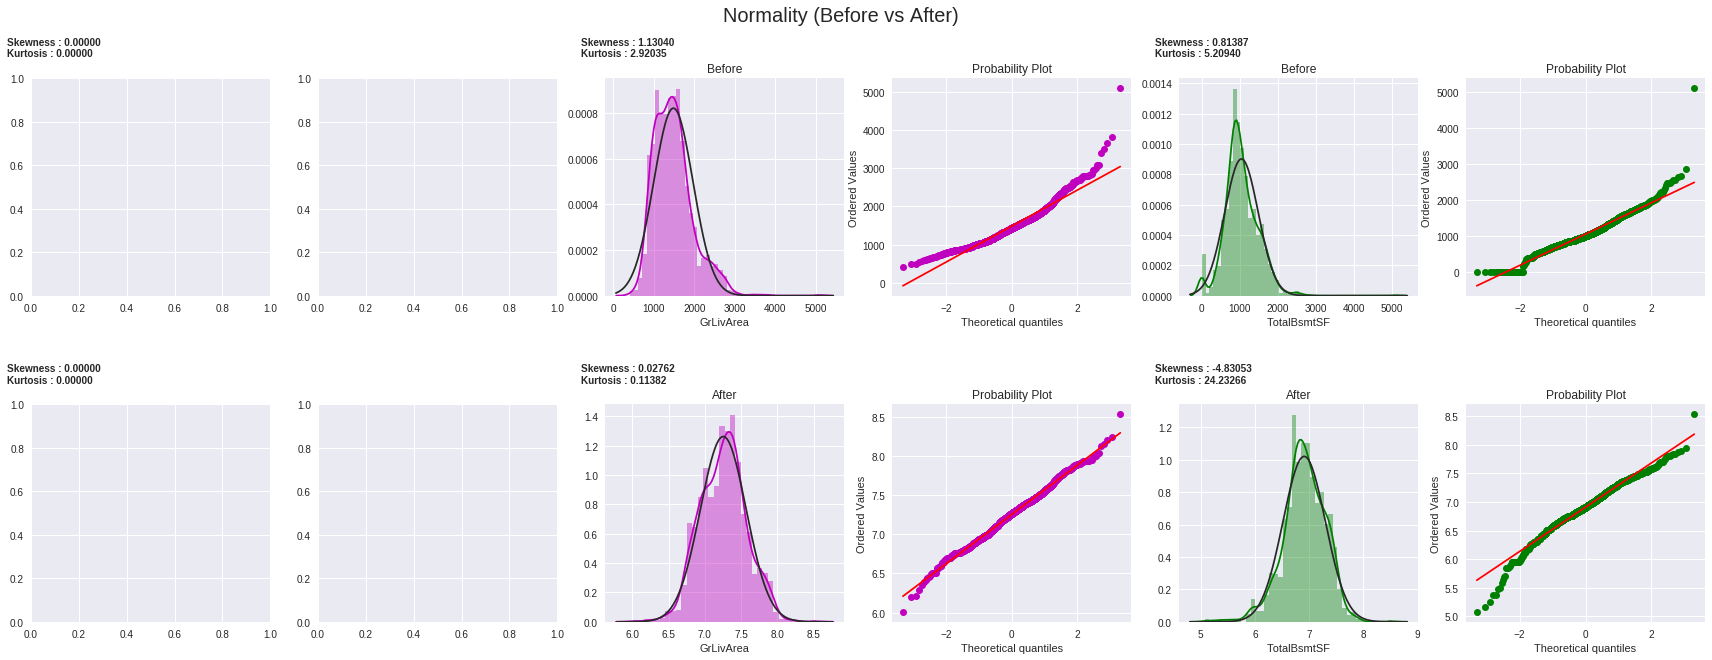

(1459, 165)

In [6]:
""" Check dataset """
hp_test_data.columns
hp_test_data.head()
hp_test_data.shape #(1459, 80)
hp_test_data.info()

""" Remove Unwanted Features  """
#Rem_cols_train is exclude ['YearBuilt','YearRemodAdd']
hp_test_data = hp_test_data.drop(Rem_cols_train,axis=1)


""" Imputate Missing Data """
missing_data = regds.disp_miss_data(hp_test_data)
Miss_cols_test = missing_data[missing_data.Total > 0].index

#Select the columns are non-number type
Object_cols = hp_test_data[Miss_cols_test].select_dtypes(exclude = [np.number]).columns
#Select the columns are non-object type
Num_cols = hp_test_data[Miss_cols_test].select_dtypes(exclude=['object']).columns

#Fill in nan with most common info in specific columns
for c in Object_cols:
    Fill_data = hp_test_data[Object_cols][c].value_counts().argmax()
    hp_test_data[c].fillna(Fill_data, inplace = True)

for c in Num_cols:
    hp_test_data[c].fillna(np.mean(hp_test_data[c]), inplace = True)

    
""" Create the new feature"""
hp_test_data = Year_interval(hp_test_data,2018)


""" Label Encoding """
#Label Encoding the ordinal variable [String --> number]
lbl_encode_train = ['LotShape','LandContour','LandSlope'
                    ,'ExterQual','ExterCond','HeatingQC'
                    ,'KitchenQual','Functional','PavedDrive']
for lbl_c in lbl_encode_train:
    hp_test_data[lbl_c],_ = pd.factorize(hp_test_data[lbl_c])

""" Solving Normality To Prevent Heteroscedasticity"""
fig, ax = plt.subplots(figsize=(30,10),nrows=2,ncols=6)
plt.subplots_adjust(hspace = 0.5)

#Data log Transformation
hp_test_data,skew_kurt_bf,skew_kurt_af = NormSolver(hp_test_data)

all_skew_kurt = {'sp_bf_skew':0,'sp_bf_kurt':0}
sp_af = {'sp_af_skew':0,'sp_af_kurt':0}

all_skew_kurt.update(skew_kurt_bf)
all_skew_kurt.update(sp_af)
all_skew_kurt.update(skew_kurt_af)

ax = ax.flat
for n, ax in enumerate(ax):
    #when meet even number
    if n%2 == 0:     
       get_skew = list(all_skew_kurt.keys())[n]    
       get_kurt = list(all_skew_kurt.keys())[n+1]  
       ax.text(-0.1, 1.1, "Skewness : {:.5f}\nKurtosis : {:.5f}".format(all_skew_kurt[get_skew],all_skew_kurt[get_kurt]), transform=ax.transAxes, 
              size=10, weight='bold')

fig.suptitle('Normality (Before vs After)',fontsize=20)
fig
plt.show()



""" One Hot Encoded """
#convert categorical variable into dummy ; Only numeric value can be fit into ML or DL model
hp_test_data = pd.get_dummies(hp_test_data)
hp_test_data.shape


""" *********************************** """
""" Columns Filter (Train vs Test Data) """
""" *********************************** """
#Get the columns that one dataframe have but other don't
diff_train_cols = hp_train_data[hp_train_data.columns.difference(hp_test_data.columns)].columns

ytrain = hp_train_data.SalePrice
xtrain = hp_train_data.drop(diff_train_cols,axis =1)
xtrain.shape

#diff_test_cols is empty for this case. test dataset columns name just matched with train dataset columns name, no extra columns in test dataset
xtest = hp_test_data
xtest.shape



##  Model training

Fitting 15 folds for each of 5 candidates, totalling 75 fits
[CV] n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3 
[CV] n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3 
[CV]  n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3, total=  22.5s
[CV] n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3 
[CV]  n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3, total=  22.5s
[CV] n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3 
[CV]  n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3, total=  17.3s
[CV] n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4, colsample_bylevel=0.3 
[CV]  n_estimators=595, min_child_weight=10, max_depth=7, colsample_bytree=0.4

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.4min


[CV]  n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4, total=  10.9s
[CV] n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4 
[CV]  n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4, total=  18.8s
[CV] n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4 
[CV]  n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4, total=  35.2s
[CV] n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4 
[CV]  n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4, total=  35.1s
[CV] n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4 
[CV]  n_estimators=458, min_child_weight=1, max_depth=8, colsample_bytree=0.4, colsample_bylevel=0.4, total=  17.4s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 22.3min finished



 All results:

 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
       colsample_bytree=0.3, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=960,
       n_jobs=-1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

 RMSLE:
0.009431952892635698

 Best hyperparameters:
{'n_estimators': 960, 'min_child_weight': 1, 'max_depth': 6, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3}


Test r2  : 0.90763 
Train r2 : 0.98367 
Train adj r2: 0.98158 


Test RMSLE  : 0.009432 
Train RMSLE : 0.003958 


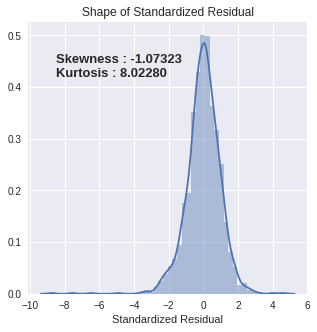

Skewness: -1.073231
Kurtosis: 8.022801


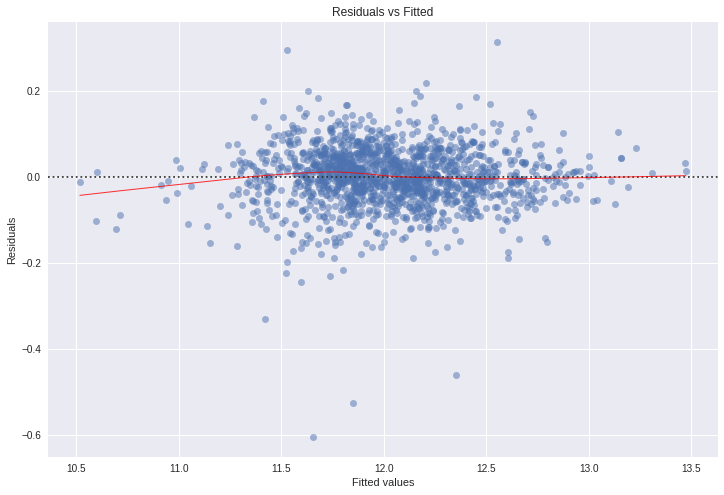

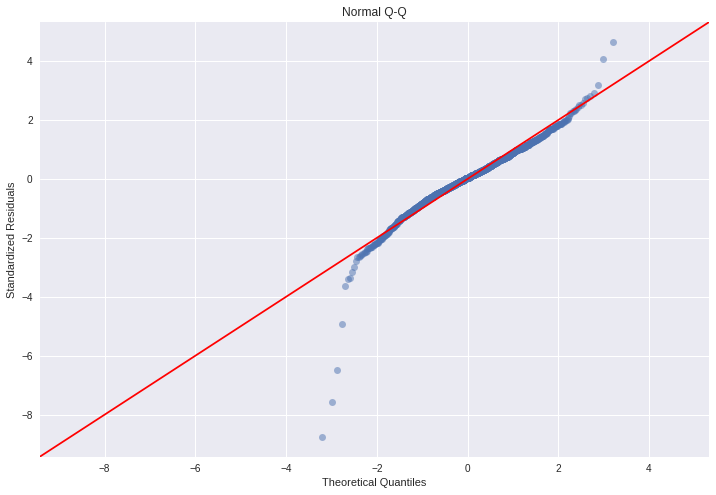

In [7]:
""" XGBoosting """
#ref: https://blog.csdn.net/qq_33880788/article/details/79463534
params = {
        'min_child_weight': [1, 5, 10],
        'colsample_bytree': np.arange(0.3,0.5,0.1),
        'colsample_bylevel': np.arange(0.3,0.5,0.1),
        'max_depth': range(6,10),
        'n_estimators': range(100,1000)
        }

folds =15
param_comb = 5
scoring = {'MSLE': 'neg_mean_squared_log_error', 'r2_score': 'r2'}
kf = KFold(n_splits=folds, random_state=42, shuffle=True)
xgb = XGBRegressor(learning_rate=0.01,gamma = 0,subsample = 1, objective='reg:linear',silent=True, nthread=-1,n_jobs=-1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,refit ='MSLE', scoring=scoring, n_jobs=-1, cv=kf.split(xtrain, ytrain), verbose=2, random_state=42,return_train_score = True)
random_search.fit(xtrain, ytrain)

""" Display Result """
print('\n All results:')
random_search.cv_results_
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n RMSLE:')
print(np.sqrt(abs(random_search.best_score_)))
print('\n Best hyperparameters:')
print(random_search.best_params_)

RS_result = pd.DataFrame(random_search.cv_results_)
print('\n')
print('Test r2  : %.5f ' %RS_result.mean_test_r2_score.max())
print('Train r2 : %.5f ' %RS_result.mean_train_r2_score.max())
print('Train adj r2: %.5f ' %reg_eval.adjusted_r2(RS_result.mean_train_r2_score.max(),xtrain,ytrain))
print('\n')
print('Test RMSLE  : %f ' %np.sqrt(abs(RS_result.mean_test_MSLE.max())))
print('Train RMSLE : %f ' %np.sqrt(abs(RS_result.mean_train_MSLE.max())))


predict_ytrain = random_search.predict(xtrain)
residual = ytrain - predict_ytrain
residual_norm_scaler = scale(np.array(residual))

mfig, ax = plt.subplots(figsize=(5,5),nrows=1,ncols=1)
sns.distplot(residual_norm_scaler,ax=ax)
ax.text(0.10, 0.8, "Skewness : {:.5f}\nKurtosis : {:.5f}".format(skew(residual_norm_scaler),kurtosis(residual_norm_scaler)), transform=ax.transAxes, 
                                                         size=13, weight='bold');

plt.xlabel('Standardized Residual')
plt.title('Shape of Standardized Residual')
plt.show()
print("Skewness: %f" % skew(residual_norm_scaler))
print("Kurtosis: %f" % kurtosis(residual_norm_scaler))

reg_eval.residual_plot(ytrain,predict_ytrain)
reg_eval.qq_plot(residual_norm_scaler)


# Prediction

In [9]:
pred_xg_test = random_search.predict(xtest)
#Convert back SalePrice from log number by using np.exp
pred_xg_test = np.exp(pred_xg_test)


"""******************"""
"""    Submissions   """
"""******************"""

submissions = pd.DataFrame({"Id": list(range(1461,len(pred_xg_test)+1461)),
                         "SalePrice": pred_xg_test})
submissions.to_csv("HousePrice_V5.csv", index=False, header=True)


,Id,SalePrice
0,1461,127873.242188
1,1462,154539.500000
2,1463,192634.437500
3,1464,191998.750000
4,1465,182067.031250
5,1466,186184.046875
6,1467,176904.515625
7,1468,171000.421875
8,1469,185615.125000
9,1470,125391.101562
